In [1]:
import glob
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

%matplotlib notebook

## 0. Split dataset

In [5]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')

In [3]:
values = dataset.iloc[:,:-3].values

In [4]:
labels = dataset['GROUP']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
label_encoder.classes_

array(['OA', 'YA'], dtype=object)

In [5]:
del values
del labels

In [6]:
values.shape

(12136, 71554)

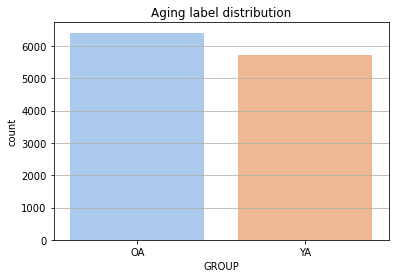

In [4]:
sns.countplot(x='GROUP', data=dataset, palette='pastel')
plt.title('Aging label distribution')
plt.grid(axis='y')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    values, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.05, random_state=42, stratify=y_train
)

In [86]:
print(len(X_train), len(X_test), len(X_val))

10375 1214 547


In [85]:
print(len(y_train[y_train == 1]) / len(y_train))
print(len(y_test[y_test == 1]) / len(y_test))
print(len(y_val[y_val == 1]) / len(y_val))

0.47151807228915665
0.471169686985173
0.4716636197440585


The age distribution is the dataset is almost 50/50. This distribution is maintained in the train, test and validation subset that we have prepared for our models.

## (Visualization)

In [4]:
def plotSurface(data, title):    
    fig = go.Figure(data=[go.Surface(z=data)])
    fig.update_traces(
        contours_z=dict(
            show=True, 
            usecolormap=True,
            highlightcolor="limegreen",
            project_z=True
        )
    )
    fig.update_layout(
            title=title,
            autosize=False,
            width=700,
            height=700,
            margin=dict(l=65, r=50, b=65, t=90),
            scene=dict(
            xaxis=dict(
                title='Time (sample num)',
                gridcolor='rgb(255, 255, 255)',
                # erolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis=dict(
                title='Channel',
                # tickvals=channels,
                # ticktext=sensor_positions,
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)'
            ),
            zaxis=dict(
                title='Sensor Value',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            aspectratio = dict(x=1, y=1, z=0.5),
            aspectmode = 'manual'
        )
    )
    fig.show()

In [21]:
def plot_trial_subject(i):
    subj_inf = dataset.index[i].split('_')
    subj = subj_inf[0]
    trial = subj_inf[1]
    stimulus = subj_inf[2]
    sample = dataset.iloc[i][:-3].values.reshape(133, 538)

    plotSurface(sample, 'Channels values in trial ' + trial + ' for subject ' + subj + '. Stimulus type ' + stimulus)

## 1. Age group experiments

Let's try different supervised models to find the best accuracy labeling the age group.

### 1.1 Perceptron

In [89]:
classifier = Perceptron(
    max_iter=500,
    alpha=0.0001,
    random_state=21)

In [90]:
classifier.fit(X_train, y_train)

Perceptron(max_iter=500, random_state=21)

In [91]:
y_pred = classifier.predict(X_test)

In [92]:
accuracy_score(y_test, y_pred)

0.913509060955519

In [93]:
y_val_pred = classifier.predict(X_val)

In [94]:
accuracy_score(y_val, y_val_pred)

0.9140767824497258

### 1.2 1 Hiden Layer Network 

In [73]:
classifier = MLPClassifier(
    max_iter=500,
    alpha=0.0001,
    random_state=21)

In [74]:
classifier.fit(X_train, y_train)

MLPClassifier(max_iter=500, random_state=21)

In [75]:
y_pred = classifier.predict(X_test)

In [76]:
accuracy_score(y_test, y_pred)

0.9324546952224053

In [77]:
y_val_pred = classifier.predict(X_val)

In [78]:
accuracy_score(y_val, y_val_pred)

0.9177330895795247

### 1.3 3 Hidden Layers Network 

In [47]:
classifier = MLPClassifier(
    hidden_layer_sizes=(100,100,100),
    max_iter=500,
    alpha=0.0001,
    random_state=21)

In [48]:
classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=21)

In [49]:
y_pred = classifier.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred)

0.9415156507413509

In [64]:
y_val_pred = classifier.predict(X_val)

In [65]:
accuracy_score(y_val, y_val_pred)

0.9195612431444241

The table below compares the accuracy for each of our models when labeling the subjects by age group. We see how this measure is pretty equal for all of our models.

In [29]:
pca_results = [[0.913509060955519, 0.9140767824497258], [0.9324546952224053, 0.9177330895795247], [0.9415156507413509, 0.9195612431444241]]
pd.DataFrame(
    data=pca_results,
    index=['Perceptron','1Hidden Layer','3Hidden Layers'],
    columns=['Test set', 'validation set']
)

,Test set,validation set
Perceptron,0.913509,0.914077
1Hidden Layer,0.932455,0.917733
3Hidden Layers,0.941516,0.919561


## 1.4 Excluding subjects for cross validation

We are getting a really good accuracy in the first try, what looks too optimistic. This can point out that our models are biased by subjects. We are going to exclude some subjects from our training/test sets and try to validate our models with those subjects that aren't include in our initial sets.

In [4]:
val_subjects = ('O200_', 'O201_', 'O204_', 'O205_', 'O206_', 'Y100_', 'Y101_', 'Y104_', 'Y105_', 'Y107_', 'Y108_')
train_subjects = dataset[~dataset.index.str.startswith(val_subjects)]
val_subjects = dataset[dataset.index.str.startswith(val_subjects)]

Now our train/test and validation sets don't share any subject in their samples, so we can confirm our model aren't learning subjects patterns but they learn group patterns instead.

In [5]:
values = train_subjects.iloc[:,:-3].values
labels = train_subjects['GROUP']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
label_encoder.classes_

array(['OA', 'YA'], dtype=object)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    values, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
)
X_val = val_subjects.iloc[:,:-3].values
y_val = label_encoder.fit_transform(val_subjects['GROUP'])

In [31]:
print(len(X_train), len(X_test), len(X_val))

9174 1020 1942


We have increased the number of samples in our validations sets to increase get a better confidence in our accuracy.

### 1.4.1 Perceptron

In [32]:
classifier = Perceptron(
    max_iter=500,
    alpha=0.0001,
    random_state=21)

In [33]:
classifier.fit(X_train, y_train)

Perceptron(max_iter=500, random_state=21)

In [34]:
y_pred = classifier.predict(X_test)

In [35]:
accuracy_score(y_test, y_pred)

0.9117647058823529

In [36]:
y_val_pred = classifier.predict(X_val)

In [37]:
accuracy_score(y_val, y_val_pred)

0.9309989701338826

### 1.4.2 1 Hiden Layer Network

In [38]:
classifier = MLPClassifier(
    max_iter=500,
    alpha=0.0001,
    random_state=21)

In [39]:
classifier.fit(X_train, y_train)

MLPClassifier(max_iter=500, random_state=21)

In [40]:
y_pred = classifier.predict(X_test)

In [41]:
accuracy_score(y_test, y_pred)

0.9343137254901961

In [42]:
y_val_pred = classifier.predict(X_val)

In [43]:
accuracy_score(y_val, y_val_pred)

0.937178166838311

### 1.4.3 3 Hiden Layers Network

In [44]:
classifier = MLPClassifier(
    hidden_layer_sizes=(100,100,100),
    max_iter=500,
    alpha=0.0001,
    random_state=21)

In [45]:
classifier.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=500, random_state=21)

In [46]:
y_pred = classifier.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)

0.9009803921568628

In [48]:
y_val_pred = classifier.predict(X_val)

In [49]:
accuracy_score(y_val, y_val_pred)

0.927394438722966

We see how our models maintain a good accuracy for the cross validation experiments excluding subjects.

In [18]:
pca_results = [[0.914, 0.931], [0.918, 0.937], [0.920, 0.927]]
pd.DataFrame(
    data=pca_results,
    index=['Perceptron','1Hidden Layer','3Hidden Layers'],
    columns=['Standard', 'Excluding Subjs']
)

,Standard,Excluding Subjs
Perceptron,0.914,0.931
1Hidden Layer,0.918,0.937
3Hidden Layers,0.920,0.927


## 1.4.4 Finding best tunning

Let's try to improve our accuracy finding the best tunning parameter for our models:

In [6]:
test_subjects = ('O200_', 'O201_', 'O204_', 'O205_', 'O206_', 'O207_', 'O208_',
                'Y100_', 'Y101_', 'Y104_', 'Y105_', 'Y107_', 'Y108_', 'Y109_')

In [7]:
train_set = dataset[~dataset.index.str.startswith(test_subjects)]
test_set = dataset[dataset.index.str.startswith(test_subjects)]

In [8]:
del dataset

In [9]:
labels = train_set['GROUP']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
label_encoder.classes_

array(['OA', 'YA'], dtype=object)

In [10]:
X_train = train_set.iloc[:,:-3].values
y_train = label_encoder.fit_transform(train_set['GROUP'])
X_test = test_set.iloc[:,:-3].values
y_test = label_encoder.fit_transform(test_set['GROUP'])

In [32]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

9608 9608 2528 2528


In [33]:
del train_set
del test_set

In [11]:
clf = MLPClassifier(
    hidden_layer_sizes=(100,100,100),
    max_iter=500,
    random_state=21)

parameter_space = {
    'alpha': np.logspace(-4, 0, 6),
}

grid_search = GridSearchCV(clf, parameter_space, cv=3)

In [ ]:
grid = grid_search.fit(X_train, y_train)

In [14]:
grid.best_params_

{'alpha': 1.0}

In [20]:
clf = MLPClassifier(
    hidden_layer_sizes=(100,100,100),
    max_iter=500,
    random_state=21,
    alpha=1)

In [21]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9588607594936709

In [15]:
clf = Perceptron(
    max_iter=500,
    random_state=21)

parameter_space = {
    'alpha': np.logspace(-4, 0, 6),
}

grid_search = GridSearchCV(clf, parameter_space, cv=3)

In [17]:
grid = grid_search.fit(X_train, y_train)

In [19]:
grid.best_params_

{'alpha': 0.0001}

In [23]:
clf = Perceptron(
    alpha=0.0001,
    max_iter=500,
    random_state=21)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9347310126582279

In [39]:
clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9620253164556962

### 1.4.5 Best accuracy for each of our models

In [6]:
subjects = list(dataset.index.map(lambda x: x.split('_')[0]))
o_subjects = list(dict.fromkeys(element for element in subjects if element[0] == 'O'))
y_subjects = list(dict.fromkeys(element for element in subjects if element[0] == 'Y'))

In [7]:
del subjects

In [34]:
def chunks_split(items, size):
    chunks = [] 
    
    for i in range(0, len(items), size):
        chunks.append(items[i:i + size])
    
    return chunks

def avg_accuracy(method):
    accuracy = []

    o_chunks = chunks_split(o_subjects, 6)
    y_chunks = chunks_split(y_subjects, 5)

    for i in range(0, 5):
        subjects = tuple(o_chunks[i] + y_chunks[i])
        
        print(subjects)
        
        train_set = dataset[~dataset.index.str.startswith(subjects)]
        test_set = dataset[dataset.index.str.startswith(subjects)]

        X_train = train_set.iloc[:,:-3].values
        y_train = label_encoder.fit_transform(train_set['GROUP'])
        X_test = test_set.iloc[:,:-3].values
        y_test = label_encoder.fit_transform(test_set['GROUP'])

        del train_set
        del test_set
        
        if(method == 'regression'):
            clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy.append(accuracy_score(y_test, y_pred))
            
        elif(method == 'perceptron'):
            clf = Perceptron(
                alpha=0.0001,
                max_iter=500,
                random_state=21).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy.append(accuracy_score(y_test, y_pred))
            
        elif(method == 'multilayer'):
            clf = MLPClassifier(
                hidden_layer_sizes=(100,100,100),
                max_iter=500,
                random_state=21,
                alpha=1).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy.append(accuracy_score(y_test, y_pred))


    return sum(accuracy) / len(accuracy)

In [10]:
regression_avg_accuracy = avg_accuracy('regression')

('O213', 'O236', 'O207', 'O235', 'O220', 'O218', 'Y124', 'Y115', 'Y128', 'Y119', 'Y132')
('O204', 'O211', 'O229', 'O224', 'O230', 'O201', 'Y127', 'Y123', 'Y102', 'Y109', 'Y105')
('O226', 'O233', 'O217', 'O202', 'O237', 'O206', 'Y117', 'Y122', 'Y131', 'Y100', 'Y110')
('O223', 'O212', 'O222', 'O200', 'O225', 'O214', 'Y114', 'Y121', 'Y129', 'Y108', 'Y120')
('O228', 'O219', 'O208', 'O216', 'O227', 'O232', 'Y101', 'Y133', 'Y104', 'Y111', 'Y125')


In [11]:
regression_avg_accuracy

0.905177150035229

In [12]:
perceptron_avg_accuracy = avg_accuracy('perceptron')

('O213', 'O236', 'O207', 'O235', 'O220', 'O218', 'Y124', 'Y115', 'Y128', 'Y119', 'Y132')
('O204', 'O211', 'O229', 'O224', 'O230', 'O201', 'Y127', 'Y123', 'Y102', 'Y109', 'Y105')
('O226', 'O233', 'O217', 'O202', 'O237', 'O206', 'Y117', 'Y122', 'Y131', 'Y100', 'Y110')
('O223', 'O212', 'O222', 'O200', 'O225', 'O214', 'Y114', 'Y121', 'Y129', 'Y108', 'Y120')
('O228', 'O219', 'O208', 'O216', 'O227', 'O232', 'Y101', 'Y133', 'Y104', 'Y111', 'Y125')


In [13]:
perceptron_avg_accuracy

0.8630540249568883

In [9]:
multilayer_avg_accuracy = avg_accuracy('multilayer')

('O213', 'O236', 'O207', 'O235', 'O220', 'O218', 'Y124', 'Y115', 'Y128', 'Y119', 'Y132')
('O204', 'O211', 'O229', 'O224', 'O230', 'O201', 'Y127', 'Y123', 'Y102', 'Y109', 'Y105')
('O226', 'O233', 'O217', 'O202', 'O237', 'O206', 'Y117', 'Y122', 'Y131', 'Y100', 'Y110')
('O223', 'O212', 'O222', 'O200', 'O225', 'O214', 'Y114', 'Y121', 'Y129', 'Y108', 'Y120')
('O228', 'O219', 'O208', 'O216', 'O227', 'O232', 'Y101', 'Y133', 'Y104', 'Y111', 'Y125')


In [10]:
multilayer_avg_accuracy

0.9014972124694506

The table below show the best accuracy obtained for each of our model when applying best tunning and cross validation excluding subjects.

As we obtained a really good accuracy, so we add experiments with a Logistic Regression model.

In [31]:
results = [0.905177150035229, 0.8630540249568883, 0.9014972124694506]
pd.DataFrame(
    data=results,
    index=['Logistic Regression', 'Perceptron', 'Multilayer'],
    columns=['Cross Validation Accuracy']
)

,Cross Validation Accuracy
Logistic Regression,0.905177
Perceptron,0.863054
Multilayer,0.901497


## 2. Stimulus Type Experiments

In [13]:
def get_encoded_classes(filter_col, value, label_col):
    labels = dataset[dataset[filter_col] == value][label_col]
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    label_encoder.classes_
    
    return labels_encoded
    
def get_sets(filter_col, value, label_col):
    values = dataset[dataset[filter_col] == value].iloc[:,:-3].values
    labels_encoded = get_encoded_classes(filter_col, value, label_col)

    return train_test_split(
        values,
        labels_encoded,
        test_size=0.1,
        random_state=42,
        stratify=labels_encoded
    )

def get_accuracy(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    log_reg_acc = accuracy_score(y_test, y_pred)

    clf = Perceptron(
        alpha=0.0001,
        max_iter=500,
        random_state=21).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    perceptron_acc = accuracy_score(y_test, y_pred)

    clf = MLPClassifier(
        hidden_layer_sizes=(100,100,100),
        max_iter=500,
        random_state=21,
        alpha=0.0006).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mlayer_acc = accuracy_score(y_test, y_pred)

    return log_reg_acc, perceptron_acc, mlayer_acc

def get_avg_accuracy(X_train, X_test, y_train, y_test):
    accuracies = []
    labels_set = set(y_train)

    for label in labels_set:
        accuracies.append(get_accuracy(X_train,
                                       X_test,
                                       labels_converter(y_train, label, labels_set),
                                       labels_converter(y_test, label, labels_set)
                                      )
                         )
        
    return np.sum(np.array(accuracies), axis=0)/3

def labels_converter(values, label, labels_set):
    return list(map(lambda x: x if x == label else len(labels_set), values))

### [IGNORE] 2.1 Identifying stimulus type for each age group

Now we will try to identify whether some of our model is able to identify the stimulus type for each of our age group. We will also compare if the accuracy differ between both groups, what could be interpreted as one of the group is reacting more drastically to each type of stimulus.

#### 2.1.1 Identifying stimulus type for the older group

In [15]:
dataset = pd.read_pickle('datasets/full_data set.pkl')
X_train, X_test, y_train, y_test = get_sets('GROUP', 'OA', 'STIMULUS')
del dataset
accuracy_stimulus_older = get_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_older)

(0.3333333333333333, 0.34735202492211836, 0.34890965732087226)


#### 2.1.2 Identifying stimulus type for the younger group

In [16]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('GROUP', 'YA', 'STIMULUS')
del dataset
accuracy_stimulus_younger = get_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_younger)

(0.4013961605584642, 0.37347294938917974, 0.3769633507853403)


In [27]:
results = [accuracy_stimulus_older, accuracy_stimulus_younger]
pd.DataFrame(
    data=results,
    index=['Elderly Group','Young Group'],
    columns=['Logistic Regression', 'Perceptron', 'Multilayer']
)

,Logistic Regression,Perceptron,Multilayer
Elderly Group,0.333333,0.347352,0.348910
Young Group,0.401396,0.373473,0.376963


### 2.1 Identifying stimulus type for each age group

#### 2.1.0 Finding best tunning 

In [3]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('GROUP', 'OA', 'STIMULUS')
del dataset

In [7]:
labels_set = list(set(y_train))
y_train = labels_converter(y_train, labels_set[0], labels_set)
y_test = labels_converter(y_test, labels_set[0], labels_set)

In [11]:
clf = MLPClassifier(
    hidden_layer_sizes=(100,100,100),
    max_iter=500,
    random_state=21)

parameter_space = {
    'alpha': np.logspace(-4, 0, 6),
}

grid_search = GridSearchCV(clf, parameter_space, cv=3)
grid = grid_search.fit(X_train, y_train)
grid.best_params_

{'alpha': 0.000630957344480193}

In [12]:
clf = Perceptron(
    max_iter=500,
    random_state=21)

parameter_space = {
    'alpha': np.logspace(-4, 0, 6),
}

grid_search = GridSearchCV(clf, parameter_space, cv=3)
grid = grid_search.fit(X_train, y_train)
grid.best_params_

{'alpha': 0.0001}

#### 2.1.1 Identifying stimulus type for the older group

In [14]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('GROUP', 'OA', 'STIMULUS')
del dataset
accuracy_stimulus_older = get_avg_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_older)

[0.57320872 0.54465213 0.58307373]


#### 2.1.2 Identifying stimulus type for the younger group

In [15]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('GROUP', 'YA', 'STIMULUS')
del dataset
accuracy_stimulus_younger = get_avg_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_younger)

[0.60267597 0.5945317  0.62361838]


In [17]:
results = [accuracy_stimulus_older, accuracy_stimulus_younger]
pd.DataFrame(
    data=results,
    index=['Elderly Group','Young Group'],
    columns=['Logistic Regression', 'Perceptron', 'Multilayer']
)

,Logistic Regression,Perceptron,Multilayer
Elderly Group,0.573209,0.544652,0.583074
Young Group,0.602676,0.594532,0.623618


In the table above we see how the accuracy of our models identifying the type of stimulus is really low. The models assign the stimulus type labels randomly for both age groups. 

This can point out that the type of stimulus aren't reflected in the EEG data that we have.

### 2.2 Identifying age group for each stimulus type

We also want to identify whether the age groups are easier to identify for any of the stimulus type.

#### 2.2.1 Identify age groups for positive stimulus

In [23]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('STIMULUS', 'POSITIVE', 'GROUP')
del dataset
accuracy_stimulus_positive = get_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_positive)

(0.922879177377892, 0.8740359897172236, 0.9023136246786633)


#### 2.2.2 Identify age groups for neutral stimulus

In [24]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('STIMULUS', 'NEUTRAL', 'GROUP')
del dataset
accuracy_stimulus_neutral = get_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_neutral)

(0.9359605911330049, 0.9137931034482759, 0.9211822660098522)


#### 2.2.3 Identify age groups for negative stimulus

In [25]:
dataset = pd.read_pickle('datasets/full_dataset.pkl')
X_train, X_test, y_train, y_test = get_sets('STIMULUS', 'NEGATIVE', 'GROUP')
del dataset
accuracy_stimulus_negative = get_accuracy(X_train, X_test, y_train, y_test)
print(accuracy_stimulus_negative)

(0.9333333333333333, 0.8928571428571429, 0.9)


In [28]:
results = [accuracy_stimulus_positive, accuracy_stimulus_neutral, accuracy_stimulus_negative]
pd.DataFrame(
    data=results,
    index=['Positive','Neutral', ' Negative'],
    columns=['Logistic Regression', 'Perceptron', 'Multilayer']
)

,Logistic Regression,Perceptron,Multilayer
Positive,0.922879,0.874036,0.902314
Neutral,0.935961,0.913793,0.921182
Negative,0.933333,0.892857,0.900000


We can see in the table above that the accuracy of our models indetifying the age group doesn't significantly change between the different stimulus type. So we can conclude that the reaction of older and younger subjects are similar between stimulus type. 